# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 2 : Essais de modélisation

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


# 1. Compréhension du problème

## 1.1 Mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython', 'squarify'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno
import sklearn
import dython
import squarify
# pour calculer VIF -Variance Influence Factor
from sklearn.linear_model import LinearRegression
# correlations catégoriques (Cramers V, Theils U)
from dython.nominal import associations


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
json==2.0.9; numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0; sklearn==1.0.2; dython==0.6.8


### 1.2.3 Configuration défauts d'affichage


In [5]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# Segmentation RFM

Pour établir des segments de clients homogènes, la [segmentation RFM](https://www.definitions-marketing.com/definition/segmentation-rfm/) prend en compte:

- la **Récence** (date de la dernière commande);
- la **Fréquence** des commandes; et
- le **Montant** (de la dernière commande ou sur une période donnée)

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.


In [9]:
OUT_DIR = 'data/out'
clients = pd.read_csv(f'{OUT_DIR}/clients.csv')
clients.head()


,customer_unique_id,dernier_achat,Frequency,MonetaryValue,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90,-161
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19,-164
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22,-586
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62,-370
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89,-337


In [10]:
df_rfm = clients[['Recency', 'Frequency', 'MonetaryValue']]
quantiles = df_rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles


,Recency,Frequency,MonetaryValue
0.25,-395.00,1.00,62.31
0.50,-268.00,1.00,105.52
0.75,-163.00,1.00,176.34


On voit un problème avec les quantiles de fréquence, car cette variable n'est pas très discriminante :


In [11]:
df_rfm['Frequency'].value_counts()


1     89969
2      2541
3       175
4        28
5         9
6         5
7         3
15        1
9         1
Name: Frequency, dtype: int64

In [12]:
pd.cut(df_rfm['Frequency'], bins=2, labels=[1, 2]).value_counts()


1    92730
2        2
Name: Frequency, dtype: int64

In [13]:
pd.cut(df_rfm['Frequency'], bins=[0, 1, 2, 100],
       labels=[1, 2, 3]).value_counts()


1    89969
2     2541
3      222
Name: Frequency, dtype: int64

In [14]:
def rfm_segmentation(df: pd.DataFrame):
    """basé sur https://gist.github.com/Anugrahn/88471aaeec74948e8ade360f80fef996"""
    rfm = df[['Recency', 'Frequency', 'MonetaryValue']].copy()
    # --Calculate R, F, M groups--

    rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[1, 2, 3, 4])
    rfm['F'] = pd.cut(df_rfm['Frequency'], bins=[
                      0, 1, 2, 100], labels=[1, 2, 3])
    rfm['M'] = pd.qcut(rfm['MonetaryValue'], q=4, labels=[1, 2, 3, 4])

    # Calculation for RFM score group (R+F+M)
    def join_rfm(x): return f"{x['R']:.0f}{x['F']:.0f}{x['M']:.0f}"
    rfm['RFM_Segment_Concat'] = rfm.apply(join_rfm, axis=1)

    # Calculate RFM_Score
    rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

    def rfm_level(df):
        """Custom segmentation basé sur RFM score"""
        if df['RFM_Score'] >= 9:
            return "Can't Loose Them"
        elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 10)):
            return 'Champions'
        elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
            return 'Loyal'
        elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
            return 'Potential'
        elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
            return 'Promising'
        elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
            return 'Needs Attention'
        else:
            return 'Require Activation'

    # Create a new variable RFM_Level
    rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
    return rfm


rfm = rfm_segmentation(clients)


In [15]:
rfm['RFM_Score'].value_counts().sort_index()


3      5853
4     11539
5     17137
6     22618
7     17322
8     11925
9      6104
10      209
11       25
Name: RFM_Score, dtype: int64

In [16]:
rfm_segments = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'R': ['min', 'max'],
    'F': ['min', 'max'],
    'M': ['min', 'max'],
    'RFM_Segment_Concat': set,
    'RFM_Score': ['min', 'max'],
    'RFM_Level': ['max', 'count']
}).sort_values(by=('RFM_Score', 'max'))
rfm_segments


Recency Frequency MonetaryValue   R       F       M      \
                      mean      mean          mean min max min max min max   
RFM_Level                                                                    
Require Activation -502.82      1.00         43.38   1   1   1   1   1   1   
Needs Attention    -412.65      1.01         62.93   1   2   1   2   1   2   
Promising          -345.80      1.02         85.84   1   3   1   3   1   3   
Potential          -288.39      1.02        162.33   1   4   1   3   1   4   
Loyal              -218.69      1.04        196.27   1   4   1   3   1   4   
Champions          -162.76      1.06        249.14   1   4   1   3   1   4   
Can't Loose Them   -110.23      1.13        370.57   2   4   1   3   2   4   

                                                    RFM_Segment_Concat  \
                                                                   set   
RFM_Level                                                                
Require Activation                                               {111}   
Needs Attention                                        {112, 121, 211}   
Promising                               {113, 212, 311, 221, 131, 122}   
Potential                {321, 222, 312, 213, 411, 123, 114, 231, 132}   
Loyal               {421, 133, 412, 331, 214, 232, 322, 313, 124, 223}   
Champions                {413, 422, 431, 323, 224, 233, 332, 134, 314}   
Can't Loose Them    {423, 324, 434, 433, 414, 333, 424, 432, 234, 334}   

                   RFM_Score               RFM_Level         
                         min max                 max  count  
RFM_Level                                                    
Require Activation         3   3  Require Activation   5853  
Needs Attention            4   4     Needs Attention  11539  
Promising                  5   5           Promising  17137  
Potential                  6   6           Potential  22618  
Loyal                      7   7               Loyal  17322  
Champions                  8   8           Champions  11925  
Can't Loose Them           9  11    Can't Loose Them   6338

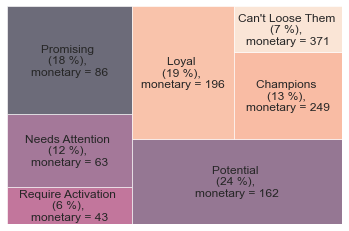

In [17]:
def plot_treemap(rfm_segments):
    rfm_summary = rfm_segments[['RFM_Level', 'MonetaryValue']]
    rfm_summary.columns = ['segment', 'nb_clients', 'monetary']
    total_clients = rfm_summary['nb_clients'].sum()
    rfm_summary = rfm_summary.assign(
        pourcentage=rfm_summary.loc[:, 'nb_clients']/total_clients * 100)

    def rfm_label(row):
        return (f"{row['segment']} \n({row['pourcentage']:.0f} %), "
                + f"\nmonetary = {row['monetary']:.0f}")
    rfm_treemap = rfm_summary.copy()
    rfm_treemap['text'] = rfm_summary.apply(lambda row: rfm_label(row), axis=1)
    # rfm_summary.loc[:,'text']= rfm_summary_text.values
    squarify.plot(sizes=rfm_treemap['nb_clients'],
                  label=rfm_treemap['text'], alpha=.6)
    plt.axis('off')
    plt.show()


plot_treemap(rfm_segments)


Require Activation : (5853, 9)
Needs Attention : (11539, 9)
Promising : (17137, 9)
Potential : (22618, 9)
Loyal : (17322, 9)
Champions : (11925, 9)
Can't Loose Them : (6338, 9)


Text(0.5, 0, 'Monetary')

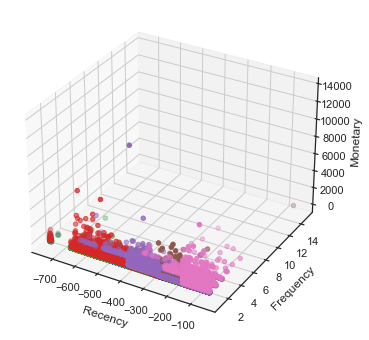

In [18]:
colors = sns.color_palette('tab10').as_hex()
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
segments = list(rfm_segments.index)
i = 0
for segment in segments:
    data = rfm[rfm['RFM_Level'] == segment]
    print(f'{segment} : {data.shape}')
    ax.scatter(data=data,
               xs='Recency', ys='Frequency', zs='MonetaryValue',
               label=segment,
               s=20,
               c=colors[i])
    i += 1
# Titre des axes et titre graphique
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")


La segmentation RFM ne discrimine pas par fréquence


"Segmentation_par_RFM.png"


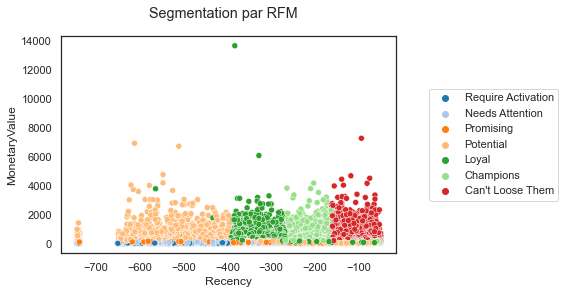

In [21]:
sns.scatterplot(data=rfm, x='Recency', y='MonetaryValue',
                hue='RFM_Level', hue_order=segments)
plt.legend(bbox_to_anchor=(1.5, 0.5),loc=5)
plt.suptitle('Segmentation par RFM')
to_png()